## Load Data

In [1]:
#Import libraries & Yahoo Finance API
import datetime, time
import yfinance as yfin
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#import seaborn as sns
from datetime import date
import itertools

from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

pd.options.display.float_format = "{:,.6f}".format #Set decimal places

In [3]:
# Starting and end dates
start = datetime.date(2020, 6, 1)
end = datetime.date(2025, 10, 18)

!pip install curl_cffi -U
from curl_cffi import requests
session = requests.Session(impersonate = 'chrome')

# Get SA stock data
df = yfin.download(["SSW.JO", "PPE.JO"], start, end, auto_adjust = False, session = session)["Adj Close"]

# Get US ETF & Treasury Yield data
df_etf = yfin.download(["SPY", "^TYX", "EZA"], start, end, auto_adjust = False, session = session)["Adj Close"]

# Get Weekend data
df_wkd = yfin.download(["USDZAR=X"], start, end, auto_adjust = False, session = session)["Adj Close"]
df_wkd1 = yfin.download(["BTC-USD"], start, end, auto_adjust = False, session = session)["Adj Close"]

#df.to_csv("market_data.csv", index = False) #save to csv file, removing indexes
#df = pd.read_csv("market_data.xls")

[*********************100%***********************]  2 of 2 completed


[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


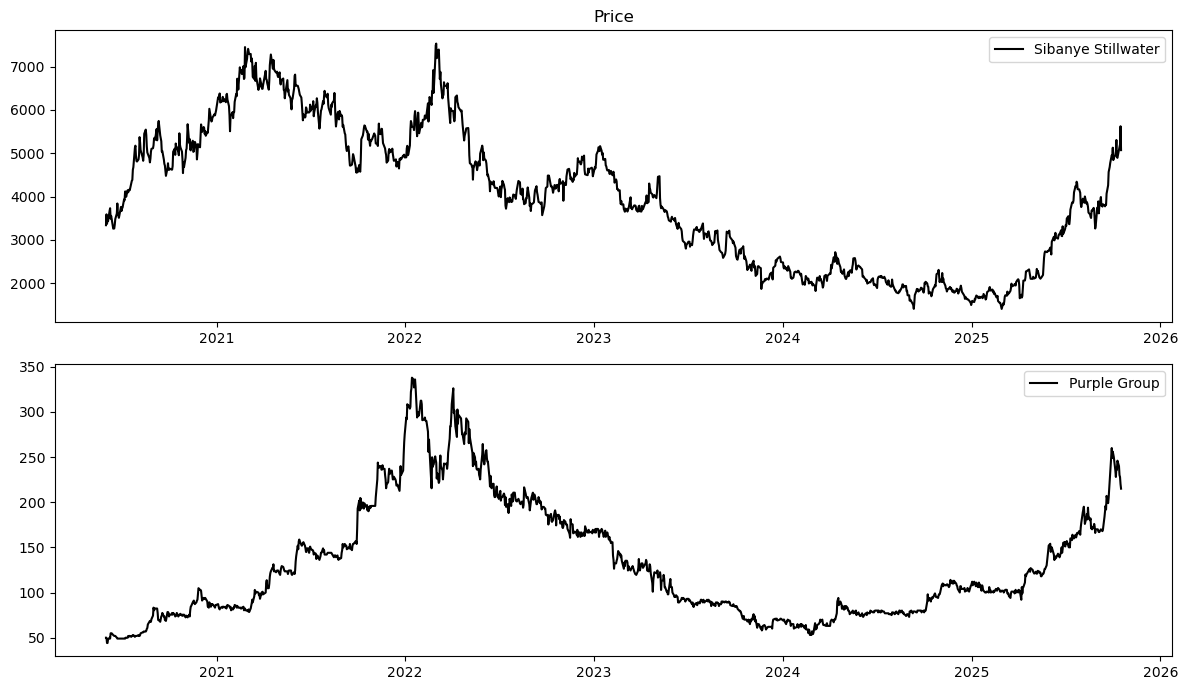

In [13]:
fig, axes = plt.subplots(2, 1, figsize=(12, 7))

# Price Plot
axes[0].plot(df["SSW.JO"].index, df["SSW.JO"], label='Sibanye Stillwater', color='black')
axes[0].set_title('Price')
axes[0].legend()

# RSI Plot
axes[1].plot(df["PPE.JO"].index, df["PPE.JO"], label='Purple Group', color='black')
axes[1].legend()

plt.tight_layout()
plt.show()

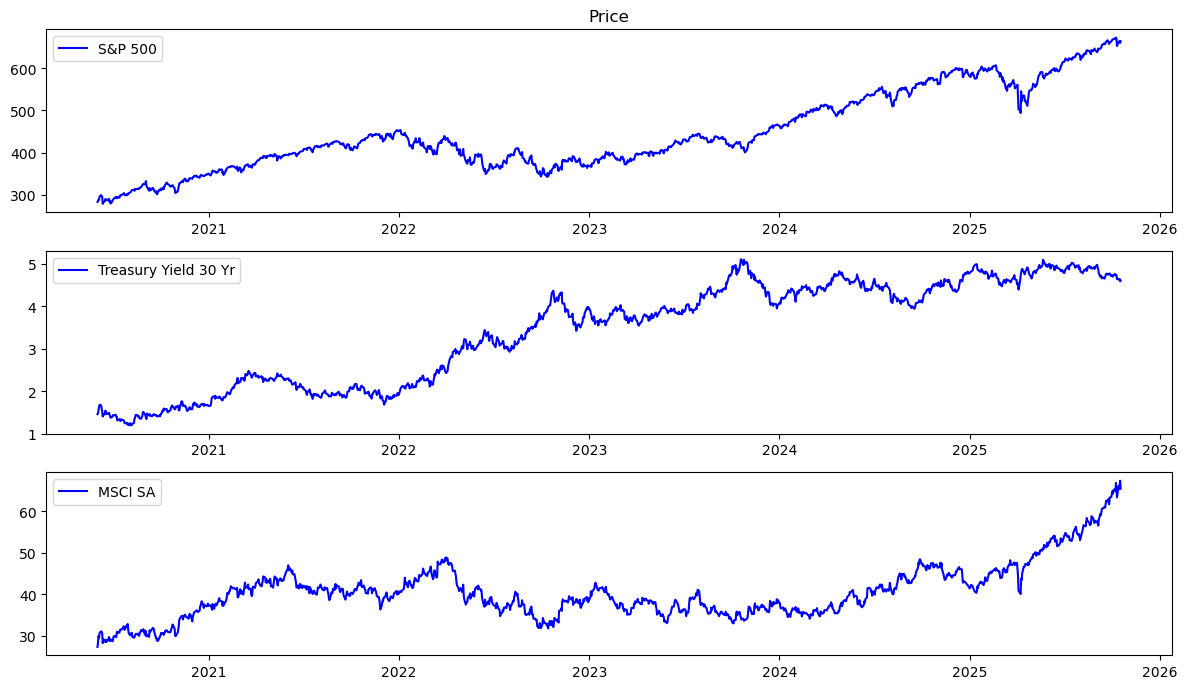

In [14]:
fig, axes = plt.subplots(3, 1, figsize=(12, 7))
axes[0].plot(df_etf["SPY"].index, df_etf["SPY"], label='S&P 500', color='blue')
axes[0].set_title('Price')
axes[0].legend()

# RSI Plot
axes[1].plot(df_etf["^TYX"].index, df_etf["^TYX"], label='Treasury Yield 30 Yr', color='blue')
axes[1].legend()

axes[2].plot(df_etf["EZA"].index, df_etf["EZA"], label='MSCI SA', color='blue')
axes[2].legend()

plt.tight_layout()
plt.show()

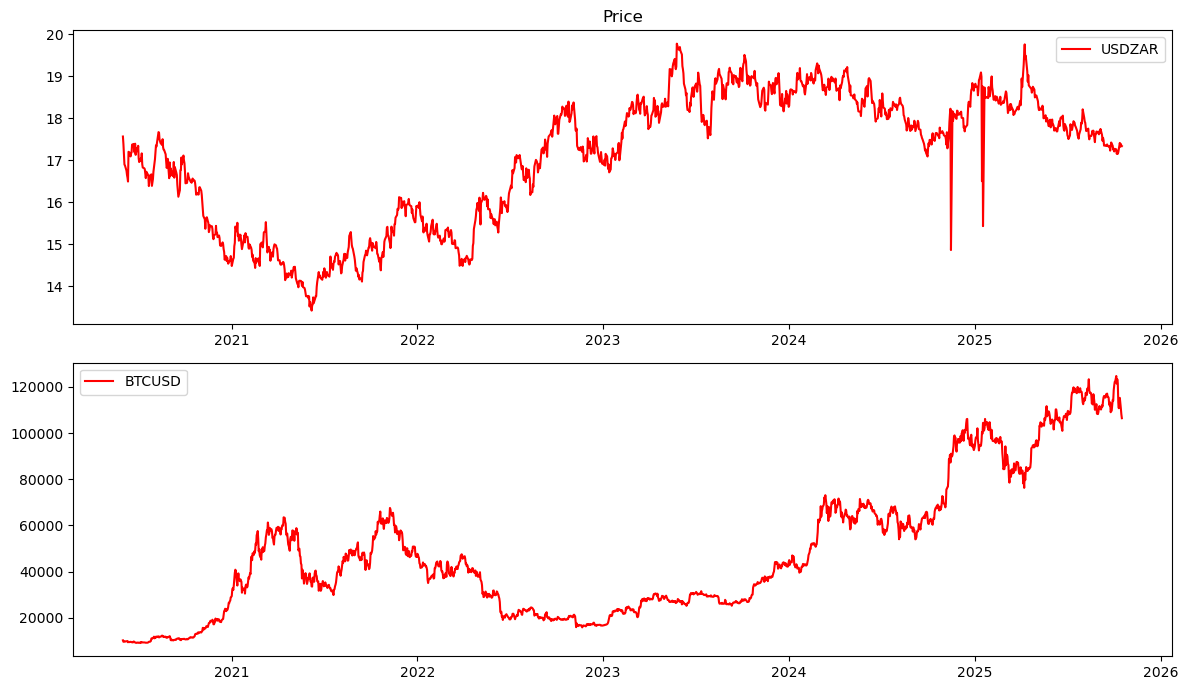

In [15]:
fig, axes = plt.subplots(2, 1, figsize=(12, 7))

# Price Plot
axes[0].plot(df_wkd["USDZAR=X"].index, df_wkd["USDZAR=X"], label='USDZAR', color='red')
axes[0].set_title('Price')
axes[0].legend()

# RSI Plot
axes[1].plot(df_wkd1["BTC-USD"].index, df_wkd1["BTC-USD"], label='BTCUSD', color='red')
axes[1].legend()

plt.tight_layout()
plt.show()

# Relative Strength Indicator

In [16]:
##RSI Calculation
def calculate_rsi(prices, period=14):
    delta = prices.diff()#.dropna() # Calculate price changes
    
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)

    gain_series = pd.Series(gain, index=prices.index)
    loss_series = pd.Series(loss, index=prices.index)

    #Smoothed averages (reacts better to changing market momentum)
    avg_gain = gain_series.ewm(alpha=1/period, min_periods=period).mean()
    avg_loss = loss_series.ewm(alpha=1/period, min_periods=period).mean()

    rs = avg_gain / avg_loss # Relative Strength
    
    rsi = 100 - (100 / (1 + rs)) # RSI formula
    return rsi

In [17]:
##Trend Filter (MA50 vs MA200)
def trnd_fltr(dat, MA_lwr, MA_upp):
    dat['MA_lwr'] = dat['Price'].rolling(MA_lwr).mean() #Shorter window
    dat['MA_upp'] = dat['Price'].rolling(MA_upp).mean() #Longer window

    # Trend Identifier
    dat['Trend'] = np.where(dat['MA_lwr'] > dat['MA_upp'], 'Uptrend', 'Downtrend')

    return dat

In [18]:
#Assign values
def rez_id(bps_change):
    #Initiate
    bps_sucs = 0
    bps_gnd = 0
    bps_fail = 0
    bps_lst = 0

    #Conditions
    if bps_change > 0:
        bps_sucs = 1
        bps_gnd = bps_change
    else:
        bps_fail = 1
        bps_lst = abs(bps_change)

    return bps_sucs, bps_fail, bps_gnd, bps_lst

In [19]:
def metr_rsi_v3(data, start_date, end_date, lookahead=3, period=14, 
                         MA_lwr=50, MA_upp=200, rsi_bnch=(70, 30), plot=True):
    # Datetime index and proper slicing
    data = data.copy()
    data.index = pd.to_datetime(data.index)
    data = data.loc[start_date:end_date].sort_index()

    # Calculate RSI
    rsi = calculate_rsi(data, period=period)
    
    # Build working DataFrame
    data = pd.DataFrame({"Price": data, "RSI": rsi})

    # Identify crossovers
    data['RSI_prev'] = data['RSI'].shift(1)
    data['RSI_Cross'] = np.select([
        (data['RSI_prev'] < rsi_bnch[1]) & (data['RSI'] >= rsi_bnch[1]),
        (data['RSI_prev'] > rsi_bnch[0]) & (data['RSI'] <= rsi_bnch[0])
    ], ['Buy_Cross', 'Sell_Cross'], default='None')

    # Base signals (threshold logic)
    data['Signal'] = np.select(
        [data['RSI'] > rsi_bnch[0],
         data['RSI'] < rsi_bnch[1]],
        ['Sell', 'Buy'],
        default='Hold'
    )

    # Trend filter
    data = trnd_fltr(data, MA_lwr, MA_upp)

    # Performance testing
    results = []
    for i in range(len(data) - lookahead):
        current_price = data['Price'].iloc[i]
        future_price = data['Price'].iloc[i + lookahead]

        signal = data['Signal'].iloc[i]
        trend = data['Trend'].iloc[i]

        if signal == 'Buy':
            bps_chng = ((future_price - current_price) / current_price) * 10000
        elif signal == 'Sell':
            bps_chng = ((current_price - future_price) / current_price) * 10000
        else:
            # Follow the prevailing trend
            if trend == 'Uptrend':
                bps_chng = ((future_price - current_price) / current_price) * 10000
            else:
                bps_chng = ((current_price - future_price) / current_price) * 10000

        bps_sucs, bps_fail, bps_gnd, bps_lst = rez_id(bps_chng)

        results.append({
            'Date': data.index[i],
            'Signal': signal,
            'Trend': trend,
            'bps_change': bps_chng,
            '#Trades_Gain': bps_sucs,
            '#Trades_Lost': bps_fail,
            'bps_gained': bps_gnd,
            'bps_lost': bps_lst,
            'RSI': data['RSI'].iloc[i],
            'RSI_Cross': data['RSI_Cross'].iloc[i]
        })

    results_df = pd.DataFrame(results).set_index('Date')

    # Performance Summary
    summary = results_df.groupby(['Signal', 'Trend'])['bps_change'].agg(['count', 'mean', 'median', 'std'])
    win_rate = results_df.groupby(['Signal', 'Trend']).apply(lambda x: (x['bps_change'] > 0).mean() * 100).rename('Win_Rate(%)')
    
    summary = summary.join(win_rate)
    summary['Sharpe'] = summary['mean'] / summary['std']
    
    # Compute win/loss ratio and expected value
    gain_stats = results_df[results_df['bps_change'] > 0]['bps_change'].mean()
    loss_stats = abs(results_df[results_df['bps_change'] < 0]['bps_change'].mean())
    overall_wr = (results_df['bps_change'] > 0).mean() * 100

    summary['Win/Loss_Ratio'] = gain_stats / loss_stats if loss_stats != 0 else np.nan
    summary['Expected_Value'] = (overall_wr/100 * gain_stats) - ((1 - overall_wr/100) * loss_stats)

    # Visualization 
    if plot:
        fig, axes = plt.subplots(2, 1, figsize=(12, 7), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

        # Price Plot
        axes[0].plot(data.index, data['Price'], label='Price', color='black')
        axes[0].plot(data['MA_lwr'], label=f'MA{MA_lwr}', linestyle='--', alpha=0.6)
        axes[0].plot(data['MA_upp'], label=f'MA{MA_upp}', linestyle='--', alpha=0.6)

        buy_points = results_df[results_df['Signal'] == 'Buy'].index
        sell_points = results_df[results_df['Signal'] == 'Sell'].index

        axes[0].scatter(buy_points, data.loc[buy_points, 'Price'], color='green', marker='^', label='Buy Signal')
        axes[0].scatter(sell_points, data.loc[sell_points, 'Price'], color='red', marker='v', label='Sell Signal')
        axes[0].set_title('Price and Signals')
        axes[0].legend()

        # RSI Plot
        axes[1].plot(data.index, data['RSI'], label='RSI', color='blue')
        axes[1].axhline(rsi_bnch[0], color='red', linestyle='--', label=f'Overbought {rsi_bnch[0]}')
        axes[1].axhline(rsi_bnch[1], color='green', linestyle='--', label=f'Oversold {rsi_bnch[1]}')
        axes[1].set_title('RSI Levels')
        axes[1].legend()

        plt.tight_layout()
        plt.show()

    return summary, results_df, data

2020-06-01 00:00:00
2025-10-17 00:00:00


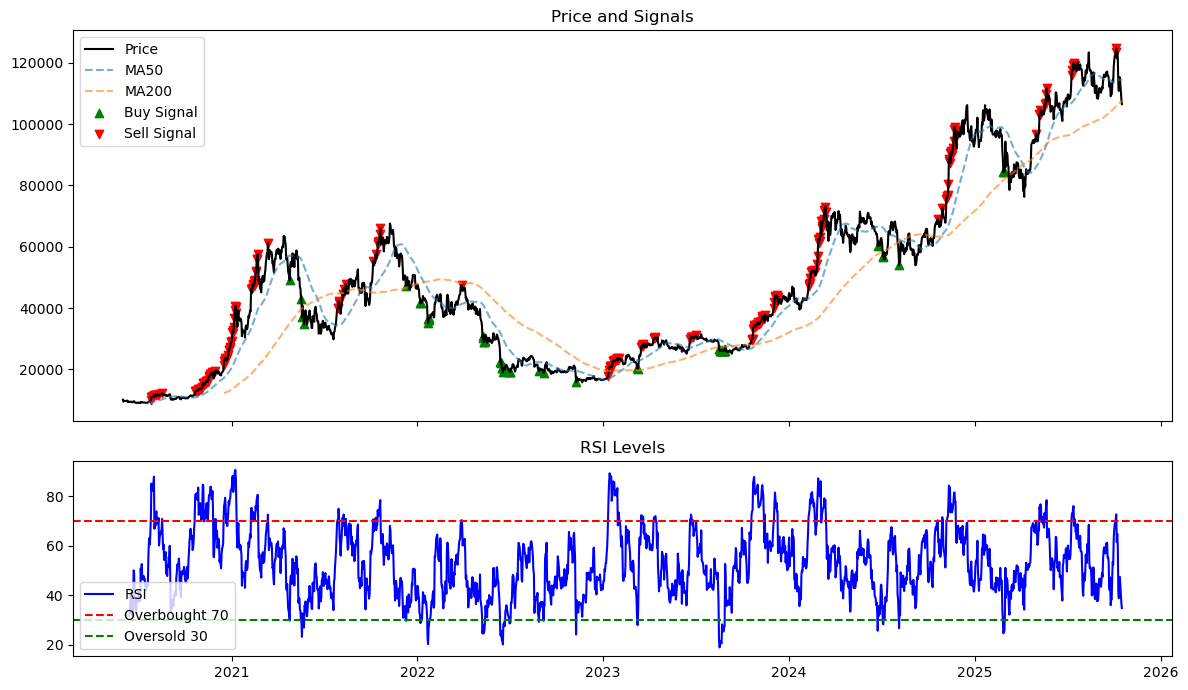

(                  count        mean      median        std  Win_Rate(%)  \
 Signal Trend                                                              
 Buy    Downtrend     25  152.088858  220.703122 636.338449    76.000000   
        Uptrend       30  293.910559  118.395652 628.088592    73.333333   
 Hold   Downtrend    725  -38.684021  -37.166719 515.087280    45.517241   
        Uptrend      943   12.958330    0.979135 503.363779    50.159067   
 Sell   Downtrend     98 -204.098536 -112.754501 508.973995    37.755102   
        Uptrend      141 -185.463870  -98.491075 601.443669    41.134752   
 
                     Sharpe  Win/Loss_Ratio  Expected_Value  
 Signal Trend                                                
 Buy    Downtrend  0.239006        0.953394      -25.157357  
        Uptrend    0.467944        0.953394      -25.157357  
 Hold   Downtrend -0.075102        0.953394      -25.157357  
        Uptrend    0.025743        0.953394      -25.157357  
 Sell   Downtrend 

In [20]:
#Function inputs:
    #Data - stock (adjusted) closing price
    #Start Date - The first date of analysis
    #End Date - The last date of analysis
    #NB: Analysis options include either duration measure (i.e. 1-,3-,6-month periods) or independently adjust start & end dates
    #Period - The duration of RSI measurement
    #Lookahead - Holding period, i.e. how many days you hold a stock before a 'new' position is taken
    #MA_lwr - Lower MA window in trend filter
    #MA_upp - Upper MA window in trend filter
    #rsi_upp - Upper bound for RSI 
    #rsi_lwr - Lower bound for RSI 

#Function outputs:
    #Summary - Computes metrics of bps change grouped by Signal & Trend
    #Results - Dataframe with results for each trading day position
    #Data - Output of RSI and Trend Filter trading strategy from price data

#An example:
print(df.index[-1] - pd.DateOffset(years=5, months=4, days=16))
print(df.index[-1])

metr_rsi_v3(data=df_wkd1["BTC-USD"] , start_date=df.index[-1] - pd.DateOffset(years=5, months=4, days=16), 
                                  end_date=df.index[-1], lookahead=3, MA_lwr=50, MA_upp=200, period=14, rsi_bnch=(70,30), plot=True)

In [30]:
# Start timer
start_time = time.time()

# Define parameter grid
param_grid = list(itertools.product(
    dats, starts, ends, lookaheads, MA_lwrs, MA_upps, periods, rsi_bnchs
))

results = []
best_score = float('-inf')
less_score = float('inf')
best_params = None
less_params = None

def evaluate_params(params):
    dat, start, end, lookahead, MA_lwr, MA_upp, period, rsi_bnch = params

    if end <= start or MA_upp <= MA_lwr or (end.date() - start.date()).days <= MA_upp or lookahead >= MA_upp:
        return None

    try:
        f_summ, f_rez, f_dat = metr_rsi_v3(
            data=dat, start_date=start, end_date=end, lookahead=lookahead,
            MA_lwr=MA_lwr, MA_upp=MA_upp, period=period, rsi_bnch=rsi_bnch, plot=False
        )
        score = f_summ['Expected_Value'].mean()

        return {
            'Data': dat.name,
            'Start': start,
            'End': end,
            'Lookahead': lookahead,
            'MA_lwr': MA_lwr,
            'MA_upp': MA_upp,
            'Period': period,
            'RSI_Benchmark': rsi_bnch,
            'Score': score
        }

    except Exception as e:
        print(f"Error for {dat.name}, {start}, {end}, {lookahead}, {MA_lwr}, {MA_upp}, {period}, {rsi_bnch}: {e}")
        return None

# Run grid search with progress bar and parallel execution
with ThreadPoolExecutor() as executor:
    for result in tqdm(executor.map(evaluate_params, param_grid), total=len(param_grid)):
        if result:
            results.append(result)
            score = result['Score']
            if score > best_score:
                best_score = score
                best_params = result
            if score < less_score:
                less_score = score
                less_params = result

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Output best and worst results
if best_params:
    print("\nBest combination found:")
    print(best_params)
    print(f"Avg BPS Gained: {best_score:.2f}")

if less_params:
    print("\nWorst combination found:")
    print(less_params)
    print(f"Avg BPS Lost: {less_score:.2f}")

# Total runtime
end_time = time.time()
print(f"\nTotal Run Time: {(end_time - start_time)/60:.2f} minutes")

100%|██████████| 27648/27648 [19:46<00:00, 23.30it/s]  



Best combination found:
{'Data': 'SSW.JO', 'Start': Timestamp('2024-10-17 00:00:00'), 'End': Timestamp('2025-07-17 00:00:00'), 'Lookahead': 20, 'MA_lwr': 30, 'MA_upp': 50, 'Period': 14, 'RSI_Benchmark': (80, 20), 'Score': 1117.6246886478204}
Avg BPS Gained: 1117.62

Worst combination found:
{'Data': 'SSW.JO', 'Start': Timestamp('2025-04-17 00:00:00'), 'End': Timestamp('2025-07-17 00:00:00'), 'Lookahead': 20, 'MA_lwr': 10, 'MA_upp': 30, 'Period': 14, 'RSI_Benchmark': (60, 40), 'Score': -2224.0026125252652}
Avg BPS Lost: -2224.00

Total Run Time: 19.83 minutes


In [23]:
# Print top results
#print(results_df[results_df["Data"] == "PPE.JO"].sort_values(by='Score', ascending=False).dropna())#.head())
print(results_df.sort_values(by='Score', ascending=False).dropna())

        Data      Start        End  Lookahead  MA_lwr  MA_upp  Period  \
2410  SSW.JO 2024-10-17 2025-07-17         20      30      50      20   
2407  SSW.JO 2024-10-17 2025-07-17         20      30      50      14   
2404  SSW.JO 2024-10-17 2025-07-17         20      30      50      10   
2389  SSW.JO 2024-10-17 2025-07-17         20      21      50      14   
2392  SSW.JO 2024-10-17 2025-07-17         20      21      50      20   
...      ...        ...        ...        ...     ...     ...     ...   
1094  SSW.JO 2025-04-17 2025-07-17         20      20      50      14   
1112  SSW.JO 2025-04-17 2025-07-17         20      21      50      14   
1103  SSW.JO 2025-04-17 2025-07-17         20      21      30      14   
1067  SSW.JO 2025-04-17 2025-07-17         20      10      30      14   
1121  SSW.JO 2025-04-17 2025-07-17         20      30      50      14   

     RSI_Benchmark         Score  
2410      (80, 20)  1,117.624689  
2407      (80, 20)  1,117.624689  
2404      (80, 20)

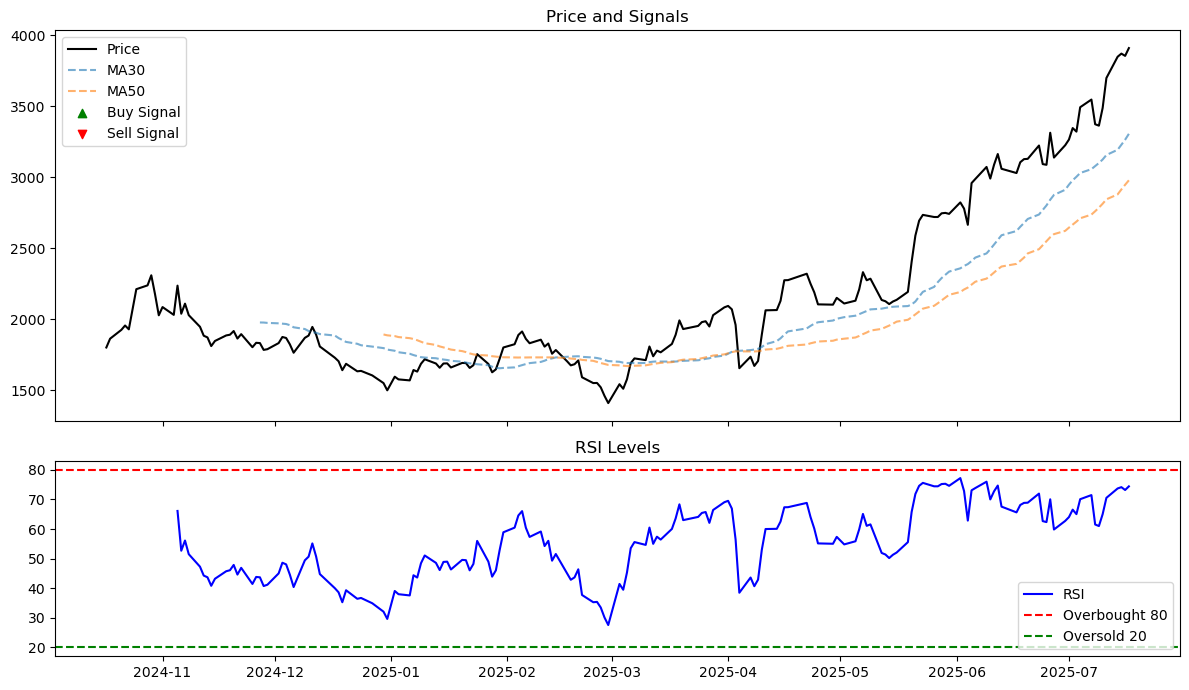

(                  count         mean       median          std  Win_Rate(%)  \
 Signal Trend                                                                  
 Hold   Downtrend     92   310.630253   400.063877 1,040.845763    59.782609   
        Uptrend       74 2,120.915068 2,056.181951 1,251.865440    94.594595   
 
                    Sharpe  Win/Loss_Ratio  Expected_Value  
 Signal Trend                                               
 Hold   Downtrend 0.298440        2.435392    1,117.624689  
        Uptrend   1.694204        2.435392    1,117.624689  ,
            Signal      Trend   bps_change  #Trades_Gain  #Trades_Lost  \
 Date                                                                    
 2024-10-17   Hold  Downtrend   -55.555556             0             1   
 2024-10-18   Hold  Downtrend    85.929108             1             0   
 2024-10-21   Hold  Downtrend   202.702703             1             0   
 2024-10-22   Hold  Downtrend   332.480818             1       

In [28]:
##Best combination
metr_rsi_v3(data=df["SSW.JO"], start_date=best_params['Start'], end_date=best_params['End'], lookahead=best_params['Lookahead'],
                                   MA_lwr=best_params['MA_lwr'], MA_upp=best_params['MA_upp'], period=best_params['Period'], 
            rsi_bnch=best_params['RSI_Benchmark'], plot=True)

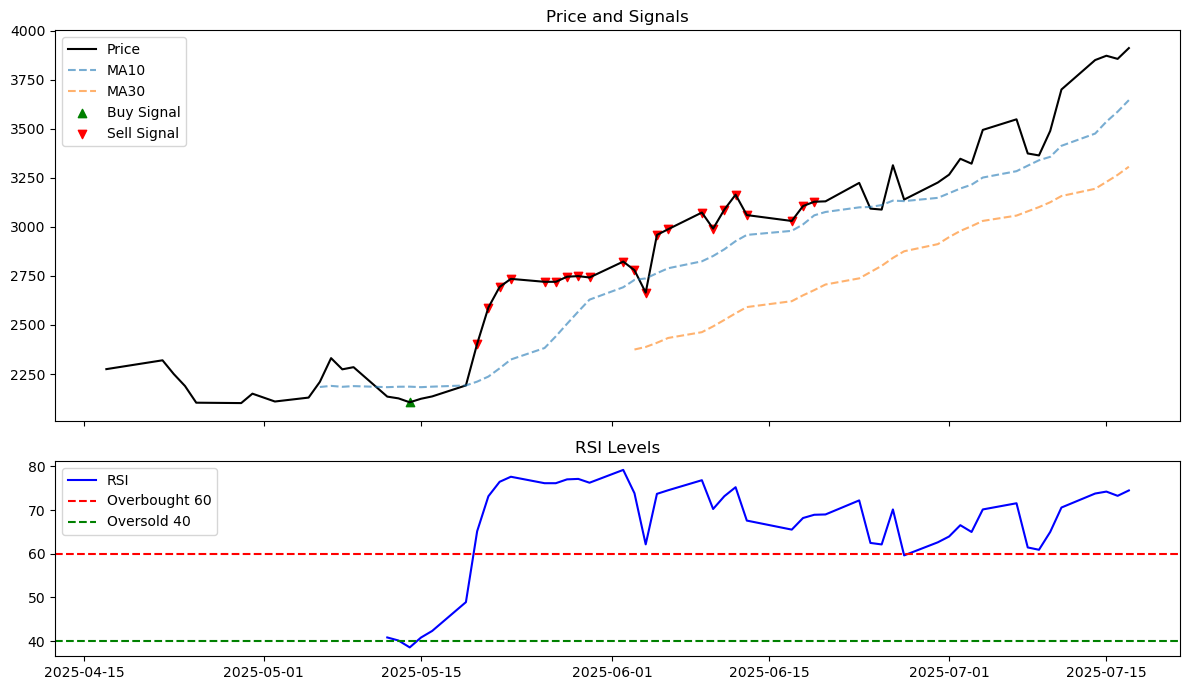

(                  count          mean        median          std  Win_Rate(%)  \
 Signal Trend                                                                    
 Buy    Downtrend      1  4,662.867996  4,662.867996          NaN   100.000000   
 Hold   Downtrend     18 -3,011.318794 -3,003.786884 1,013.674509     0.000000   
 Sell   Downtrend     10 -1,795.417662 -1,691.773111   474.062390     0.000000   
        Uptrend       12 -1,974.088350 -1,959.032002   589.850309     0.000000   
 
                     Sharpe  Win/Loss_Ratio  Expected_Value  
 Signal Trend                                                
 Buy    Downtrend       NaN        1.945964   -2,224.002613  
 Hold   Downtrend -2.970696        1.945964   -2,224.002613  
 Sell   Downtrend -3.787302        1.945964   -2,224.002613  
        Uptrend   -3.346762        1.945964   -2,224.002613  ,
            Signal      Trend    bps_change  #Trades_Gain  #Trades_Lost  \
 Date                                                     

In [29]:
##Worst combination  
metr_rsi_v3(data=df["SSW.JO"], start_date=less_params['Start'], end_date=less_params['End'], lookahead=less_params['Lookahead'],
                                   MA_lwr=less_params['MA_lwr'], MA_upp=less_params['MA_upp'], period=less_params['Period'], 
            rsi_bnch=less_params['RSI_Benchmark'], plot=True)

# Bollinger Bands

In [ ]:
# Define parameters
window_size = 20
num_std = 2

rolling_dat = df.index[window_size-1:]

# Calculate rolling mean and standard deviation
rolling_mean = np.convolve(df["SSW.JO"], np.ones(window_size)/window_size, mode='valid')
rolling_std = np.std([df["SSW.JO"][i:i+window_size] for i in range(len(df["SSW.JO"])-window_size+1)], axis=1)

# Calculate Bollinger Bands
upper_band = rolling_mean + num_std * rolling_std
lower_band = rolling_mean - num_std * rolling_std

rolling_df = pd.DataFrame({
                "Date": rolling_dat,
                "Mean": rolling_mean,
                "Std": rolling_std,
                "Upper": upper_band,
                "Lower": lower_band})

#Set index
rolling_df = rolling_df.set_index("Date")

In [ ]:
# Plotting
plt.figure(figsize=(12, 6))

# Plot Closing Prices
plt.subplot(2, 1, 1)
plt.plot(df["SSW.JO"], label='Closing Price')
plt.title('Stock Price and BB (20) of Sibanye Stillwater Ltd')
plt.legend()
plt.ylabel('Price (cents)')

# Plot RSI
plt.subplot(2, 1, 2)
plt.plot(rolling_df["Mean"], label='Rolling Mean', color='red')
plt.plot(rolling_df["Upper"], label='Upper Bollinger Band', color='green')
plt.plot(rolling_df["Lower"], label='Lower Bollinger Band', color='green')
plt.legend()
plt.xlabel('Days')
plt.tight_layout()
plt.show()

In [ ]:
#Technical Works!

# Plotting
plt.figure(figsize=(12, 6))

# Plot Closing Prices
plt.subplot(2, 1, 1)
plt.plot(df.loc["2025-01-01":"2025-10-01", "SSW.JO"], label='Closing Price')
plt.title('Stock Price and BB (20) of Sibanye Stillwater Ltd')
plt.legend()
plt.ylabel('Price (cents)')

# Plot RSI
plt.subplot(2, 1, 2)
plt.plot(rolling_df.loc["2025-01-01":"2025-10-01", "Mean"], label='Rolling Mean', color='red')
plt.plot(rolling_df.loc["2025-01-01":"2025-10-01", "Upper"], label='Upper Bollinger Band', color='green')
plt.plot(rolling_df.loc["2025-01-01":"2025-10-01", "Lower"], label='Lower Bollinger Band', color='green')
plt.legend()
plt.xlabel('Days')
plt.tight_layout()
plt.show()

In [ ]:
#Technical Does Not Works!

# Plotting
plt.figure(figsize=(12, 6))

# Plot Closing Prices
plt.subplot(2, 1, 1)
plt.plot(df.loc["2024-03-01":"2024-06-01", "SSW.JO"], label='Closing Price')
plt.title('Stock Price and BB (20) of Sibanye Stillwater Ltd')
plt.legend()
plt.ylabel('Price (cents)')

# Plot RSI
plt.subplot(2, 1, 2)
plt.plot(rolling_df.loc["2024-03-01":"2024-06-01", "Mean"], label='Rolling Mean', color='red')
plt.plot(rolling_df.loc["2024-03-01":"2024-06-01", "Upper"], label='Upper Bollinger Band', color='green')
plt.plot(rolling_df.loc["2024-03-01":"2024-06-01", "Lower"], label='Lower Bollinger Band', color='green')
plt.legend()
plt.xlabel('Days')
plt.tight_layout()
plt.show()

# Moving Average Convergence/Divergence Oscillator (MACD)

In [ ]:
# Function to calculate MACD and Signal Line
def calculate_macd(prices, short_window=12, long_window=26, signal_window=9):
   short_ema = prices.ewm(span=short_window, adjust=False).mean() # Short-term EMA
   long_ema = prices.ewm(span=long_window, adjust=False).mean() # Long-term EMA
    
   macd_line = short_ema - long_ema # MACD Line
    
   signal_line = macd_line.ewm(span=signal_window, adjust=False).mean() # Signal Line
    
   return macd_line, signal_line

In [ ]:
# Calculate MACD and Signal Line
macd_line, signal_line = calculate_macd(df["SSW.JO"])

# Plotting the results
plt.figure(figsize=(12, 6))

# Plot Closing Prices
plt.subplot(2, 1, 1)
plt.plot(df["SSW.JO"], label='Closing Price')
plt.title('Stock Price and MACD of Sibanye Stillwater Ltd')
plt.legend()
plt.ylabel('Price (cents)')

# Plot RSI
plt.subplot(2, 1, 2)
plt.plot(macd_line, label='MACD Line', color='red')
plt.plot(signal_line, label='Signal Line', color='green')
plt.legend()
plt.tight_layout()
plt.xlabel('Days')
plt.show()